# Train transformer

In [1]:
import torch
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from torch.cuda.amp import GradScaler, autocast
import GPUtil

from transformer_implementation import Transformer, Tokenizer, TransformerConfig, DataLoaderFactory
from utils import training_loop, plot_losses, estimate_loss

## Init
### Tokenizer

In [2]:
# init tokenizer
tokenizer = Tokenizer()

### Config

In [3]:
# init config
config = TransformerConfig(
    vocab_size = tokenizer.vocab_size(),
    block_size = 64,
    n_layer = 6, # 6,
    n_head = 8,
    n_embd = 512,
    max_epochs=150,
    train_data_size = 30000, # batch * 500 iters
    max_iters = int(30000/12)-1, # dataset_size / batch_size
    eval_iters = int(3000/12)-1, # val_dataset_size / batch_size
    BOS_IDX = tokenizer.BOS_IDX,
    EOS_IDX = tokenizer.EOS_IDX,
    PAD_IDX = tokenizer.PAD_IDX,
)

#### Multi Process config

In [4]:
if config.ddp:
    init_process_group(backend=config.backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])
    config.device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    config.gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1

torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[config.dtype]
ctx = nullcontext() if config.device_type == 'cpu' else torch.amp.autocast(device_type=config.device_type, dtype=ptdtype)


gpu_ok = False
if torch.cuda.is_available():
    device_cap = torch.cuda.get_device_capability()
    if device_cap in ((7, 0), (8, 0), (9, 0)):
        gpu_ok = True

if not gpu_ok:
    print(
        "GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected."
    )
config.compile = gpu_ok

GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected.


In [5]:
print(config)

TransformerConfig:

Tokenizer:
+---------------------+
| vocab_size : 100277 |
| BOS_IDX    : 100264 |
| EOS_IDX    : 100265 |
| PAD_IDX    : 100266 |
+---------------------+

Data:
+---------------------------------+
| block_size              : 64    |
| batch_size              : 12    |
| train_data_size         : 30000 |
| grad_accumulation_steps : 40    |
+---------------------------------+

Model:
+-----------------+
| n_layer : 6     |
| n_head  : 8     |
| n_embd  : 512   |
| dropout : 0.1   |
| bias    : 0     |
+-----------------+

Training Loop:
+-------------------+
| max_epochs : 150  |
| max_iters  : 2499 |
| eval_iters : 249  |
+-------------------+

AdamW Optimizer:
+------------------------+
| learning_rate : 0.0006 |
| beta1         : 0.9    |
| beta2         : 0.95   |
| weight_decay  : 0.1    |
| eps           : 1e-09  |
+------------------------+

System:
+-----------------------+
| device_type : cuda    |
| device      : cuda    |
| dtype       : float16 |
| compil

### Loading dataset

In [6]:
# loading dataset
dataset = DataLoaderFactory(config.block_size, config.batch_size, tokenizer, config.device, config.train_data_size)
len(dataset)

Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


Number of data by datasets splits
Train		: 30000	-> 2500.0
Validation	: 3000		-> 250.0
Test		: 3003		-> 250.25
Total		: 36003


36003

### Model

#### Initial gpu usage:

In [7]:
def get_gpu_memory():
    GPUs = GPUtil.getGPUs()
    gpu = GPUs[0]
    return gpu.memoryUsed

In [8]:
print(f"Initial GPU Memory Used: {get_gpu_memory()} MB")

Initial GPU Memory Used: 364.0 MB


In [9]:
# Create model
model = Transformer(config)
model.train()
model = model.to(config.device)

# for Accumulating Gradients for Larger Effective Batch Size. If enabled=False scaler is a no-op
scaler = GradScaler(enabled=(config.dtype == 'float16')) # Initialize GradScaler

# create a PyTorch optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.98), eps=1e-9)
optimizer = model.configure_optimizers(weight_decay=config.weight_decay, learning_rate=config.learning_rate, betas=(config.beta1, config.beta2), eps=config.eps, device_type=config.device_type)

# compile the model
if config.compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model) # requires PyTorch 2.0

# wrap model into DDP container
if config.ddp:
    model = DDP(model, device_ids=[ddp_local_rank])

Number of Encoder parameters: 70.22M
number of Decoder parameters: 76.52M
Total number of parameters: 146.74M
num decayed parameter tensors: 100, with 146,789,376 parameters
num non-decayed parameter tensors: 32, with 16,384 parameters


#### GPU after Loading Model

## Training

In [10]:
print(f"GPU Memory Used After Loading Model: {get_gpu_memory()} MB")

GPU Memory Used After Loading Model: 996.0 MB


In [11]:
CALCULATE_MEMORY = False
if CALCULATE_MEMORY:
    # Get the initial memory usage
    initial_memory = get_gpu_memory()
    
    batch = dataset.get_batch('train')
    
    for i in range(5):
        n_batch = next(batch)
        xb = n_batch['inputs']
        yb = n_batch['targets']

        # autocast means part of the model run in FP16 to save memory
        with autocast():
            # Forward pass
            logits, loss = model(xb, yb)
        
        # Calculate the memory used
        memory_used = get_gpu_memory() - initial_memory
        
        print(f"Memory used for a batch {i}: {memory_used} MB")
        
        # Make sure to zero out the gradients and free the memory
        model.zero_grad()
        torch.cuda.empty_cache()
    assert "a" == "b"

**Memory History: Before Quantization 5006.0 MB**

### Loop

In [12]:
losses_list = training_loop(model, ctx, optimizer, scaler, dataset, config, saved_path = "./out/transformer-train2.pth")

Train loss nan, Val loss nan, Saved nan:   0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

C:\Users\thiba\.virtualenvs\transformer-LWcVpt7F\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/249 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/249 [00:00<?, ?it/s]

Early stopping


### Plotting losses

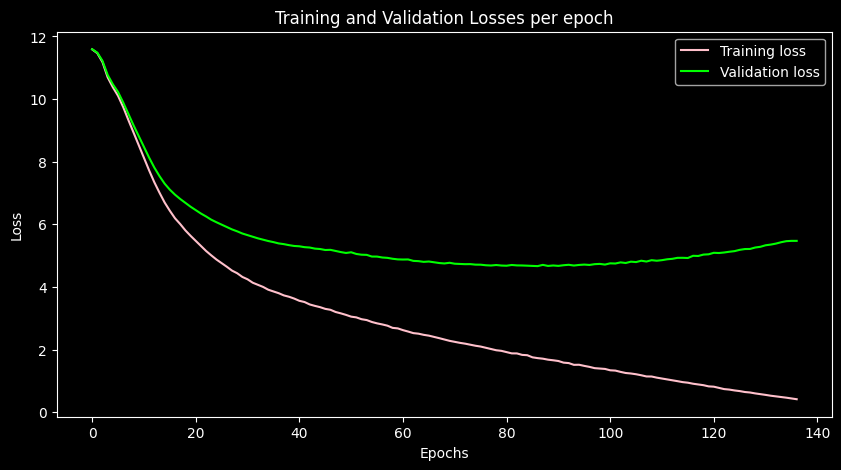

In [13]:
# Call the function
plot_losses(losses_list)

## Testing

In [14]:
test_loss = estimate_loss(model, ctx, dataset, config, ['test'])

Evaluation - test:   0%|          | 0/249 [00:00<?, ?it/s]

C:\Users\thiba\.virtualenvs\transformer-LWcVpt7F\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [15]:
print(f"Test loss = {test_loss['test'].item():4f}")

Test loss = 5.894730


In [20]:
torch.save(model.state_dict(), "./out/train_model.pth")

## Find specific exemple from overfitted dataset

In [16]:
b = dataset.get_batch('train')
nb = next(b)

In [17]:
nb['translation']['en'][0]

'This is an issue which, as you will understand, will have to be addressed at IGC level and is an issue that only a Special European Council can authorise the Portuguese Presidency to pursue, because this kind of issue falls outside the institutional framework in which the forthcoming Intergovernmental Conference will take place.'

In [18]:
nb['translation']['fr'][0]

"C'est une question qui devra être étudiée, vous le comprendrez, au niveau de la Conférence intergouvernementale. Il s'agit là d'un thème que seul un Conseil européen extraordinaire peut autoriser car c'est une question située hors du cadre institutionnel dans lequel s'inscrit la prochaine Conférence intergouvernementale."